Datos obtenidos correctamente
Mejores parámetros: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
MAE: 0.0
RMSE: 0.0
MAPE: 0.0%
Accuracy: 100.0%
Órdenes predichas para 2024-07-01: 2.0


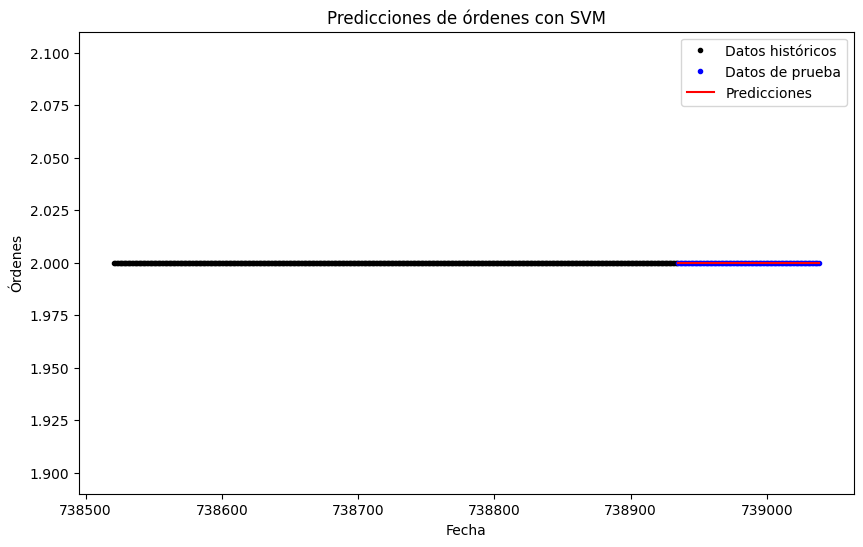

In [5]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# URL de la API
api_url = "http://localhost:3000/api/dashboard/orders-by-date-range?start=2023-01-01&end=2024-06-01"

# Hacer la solicitud GET a la API
response = requests.get(api_url)

# Intentar decodificar la respuesta como JSON
try:
    data = response.json()
    print("Datos obtenidos correctamente")
except json.JSONDecodeError as e:
    print(f"Error decodificando JSON: {e}")
    data = None

# Convertir los datos a un DataFrame
df = pd.DataFrame(data['data'])
df['entry_date'] = pd.to_datetime(df['entry_date'])

# Eliminar la información de zona horaria
df['entry_date'] = df['entry_date'].dt.tz_localize(None)

df = df.drop_duplicates()
df = df.rename(columns={"entry_date": "ds", "total_orders": "y"})

# Agregar características adicionales
df['day_of_week'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['quarter'] = df['ds'].dt.quarter
df['day_of_year'] = df['ds'].dt.dayofyear
df['week_of_year'] = df['ds'].dt.isocalendar().week

# Preparar los datos para el entrenamiento
df['ds'] = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal)
X = df[['ds', 'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year']]
y = df['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de hiperparámetros usando GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Entrenar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = best_model.predict(X_test_scaled)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"Accuracy: {accuracy}%")

# Predicción para una fecha específica
specific_date = '2024-07-01'
specific_date_ordinal = pd.to_datetime(specific_date).toordinal()
specific_features = pd.DataFrame({
    'ds': [specific_date_ordinal],
    'day_of_week': [pd.to_datetime(specific_date).dayofweek],
    'month': [pd.to_datetime(specific_date).month],
    'quarter': [pd.to_datetime(specific_date).quarter],
    'day_of_year': [pd.to_datetime(specific_date).dayofyear],
    'week_of_year': [pd.to_datetime(specific_date).isocalendar()[1]]
})

specific_features_scaled = scaler.transform(specific_features)
predicted_order = best_model.predict(specific_features_scaled)

print(f"Órdenes predichas para {specific_date}: {predicted_order[0]}")

# Visualizar las predicciones
plt.figure(figsize=(10, 6))

# Graficar los datos históricos
plt.plot(X_train['ds'], y_train, 'ko', markersize=3, label='Datos históricos')
plt.plot(X_test['ds'], y_test, 'bo', markersize=3, label='Datos de prueba')
plt.plot(X_test['ds'], y_pred, 'r-', label='Predicciones')

plt.xlabel('Fecha')
plt.ylabel('Órdenes')
plt.title('Predicciones de órdenes con SVM')
plt.legend()

plt.show()

In [6]:
import joblib

# Guardar el modelo y el escalador
joblib.dump(best_model, 'svr_model_f.pkl')
joblib.dump(scaler, 'scaler_f.pkl')


['scaler_f.pkl']

518
Mejores parámetros: {'C': 1000, 'gamma': 'auto', 'kernel': 'rbf'}
MAE: 122.51648530318347
RMSE: 146.47709825133157
MAPE: 20.50422968566992%
Accuracy: 79.49577031433009%
Órdenes predichas para 2024-07-01: 459.9991233292159


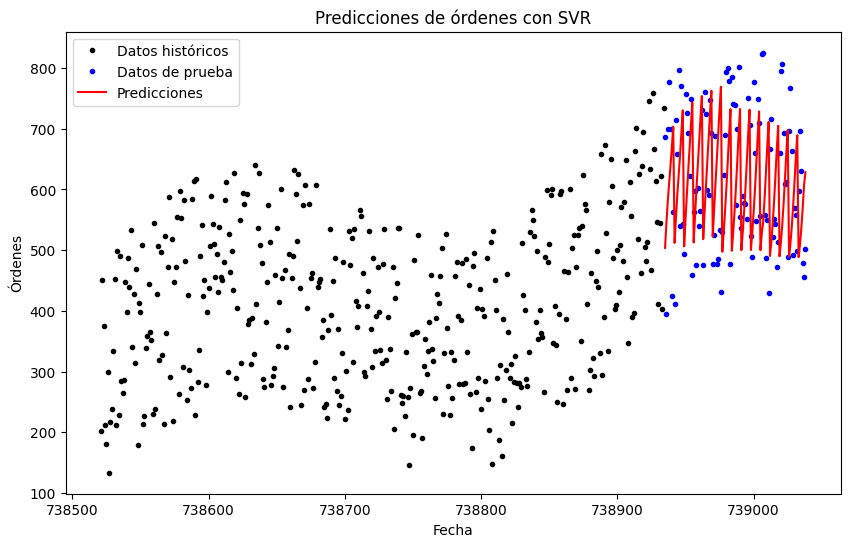

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt

# Generar fechas
start_date = '2023-01-01'
end_date = '2024-06-01'
dates = pd.date_range(start=start_date, end=end_date, freq='D')

# Generar órdenes aleatorias con una tendencia lineal y estacionalidad
np.random.seed(42)
orders = np.random.randint(100, 500, size=len(dates)) + np.arange(len(dates)) * 0.5 + np.sin(np.arange(len(dates)) * 2 * np.pi / 365) * 100

# Crear DataFrame
df = pd.DataFrame({'ds': dates, 'y': orders})

print(len(df))
# Agregar características adicionales
df['day_of_week'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['quarter'] = df['ds'].dt.quarter
df['day_of_year'] = df['ds'].dt.dayofyear
df['week_of_year'] = df['ds'].dt.isocalendar().week

# Convertir fechas a ordinales
df['ds'] = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal)

# Preparar los datos para el entrenamiento
X = df[['ds', 'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year']]
y = df['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de hiperparámetros usando GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Entrenar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = best_model.predict(X_test_scaled)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"Accuracy: {accuracy}%")

# Predicción para una fecha específica
specific_date = '2024-07-01'
specific_date_ordinal = pd.to_datetime(specific_date).toordinal()
specific_features = pd.DataFrame({
    'ds': [specific_date_ordinal],
    'day_of_week': [pd.to_datetime(specific_date).dayofweek],
    'month': [pd.to_datetime(specific_date).month],
    'quarter': [pd.to_datetime(specific_date).quarter],
    'day_of_year': [pd.to_datetime(specific_date).dayofyear],
    'week_of_year': [pd.to_datetime(specific_date).isocalendar()[1]]
})

specific_features_scaled = scaler.transform(specific_features)
predicted_order = best_model.predict(specific_features_scaled)

print(f"Órdenes predichas para {specific_date}: {predicted_order[0]}")

# Visualizar las predicciones
plt.figure(figsize=(10, 6))

# Graficar los datos históricos
plt.plot(X_train['ds'], y_train, 'ko', markersize=3, label='Datos históricos')
plt.plot(X_test['ds'], y_test, 'bo', markersize=3, label='Datos de prueba')
plt.plot(X_test['ds'], y_pred, 'r-', label='Predicciones')

plt.xlabel('Fecha')
plt.ylabel('Órdenes')
plt.title('Predicciones de órdenes con SVR')
plt.legend()

plt.show()


MAE: 0.0
RMSE: 0.0
MAPE: 0.0%
Accuracy: 100.0%
Órdenes predichas para 2024-07-01: 2.0


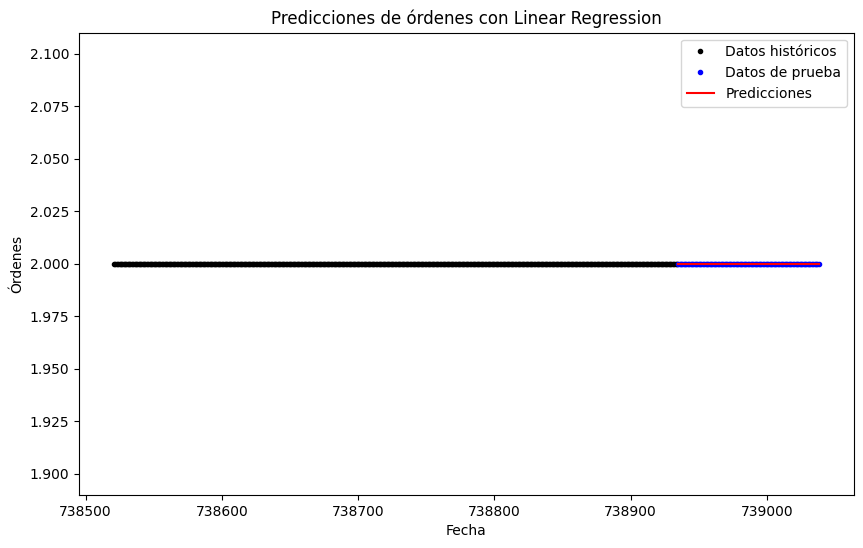

In [7]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# URL de la API
api_url = "http://localhost:3000/api/dashboard/orders-by-date-range?start=2022-01-01&end=2024-06-01"

# Hacer la solicitud GET a la API
response = requests.get(api_url)
data = response.json()

# Convertir los datos a un DataFrame
df = pd.DataFrame(data['data'])
df['entry_date'] = pd.to_datetime(df['entry_date']).dt.tz_localize(None)

# Preparar los datos
df = df.drop_duplicates().rename(columns={"entry_date": "ds", "total_orders": "y"})
df['day_of_week'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['quarter'] = df['ds'].dt.quarter
df['day_of_year'] = df['ds'].dt.dayofyear
df['week_of_year'] = df['ds'].dt.isocalendar().week
df['ds'] = df['ds'].map(pd.Timestamp.toordinal)

# Dividir los datos en conjuntos de entrenamiento y prueba
X = df[['ds', 'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year']]
y = df['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo con Linear Regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = model.predict(X_test_scaled)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"Accuracy: {accuracy}%")

# Predicción para una fecha específica
specific_date = '2024-07-01'
specific_date_ordinal = pd.to_datetime(specific_date).toordinal()
specific_features = pd.DataFrame({
    'ds': [specific_date_ordinal],
    'day_of_week': [pd.to_datetime(specific_date).dayofweek],
    'month': [pd.to_datetime(specific_date).month],
    'quarter': [pd.to_datetime(specific_date).quarter],
    'day_of_year': [pd.to_datetime(specific_date).dayofyear],
    'week_of_year': [pd.to_datetime(specific_date).isocalendar()[1]]
})

specific_features_scaled = scaler.transform(specific_features)
predicted_order = model.predict(specific_features_scaled)

print(f"Órdenes predichas para {specific_date}: {predicted_order[0]}")

# Visualizar las predicciones
plt.figure(figsize=(10, 6))

# Graficar los datos históricos
plt.plot(X_train['ds'], y_train, 'ko', markersize=3, label='Datos históricos')
plt.plot(X_test['ds'], y_test, 'bo', markersize=3, label='Datos de prueba')
plt.plot(X_test['ds'], y_pred, 'r-', label='Predicciones')

plt.xlabel('Fecha')
plt.ylabel('Órdenes')
plt.title('Predicciones de órdenes con Linear Regression')
plt.legend()

plt.show()


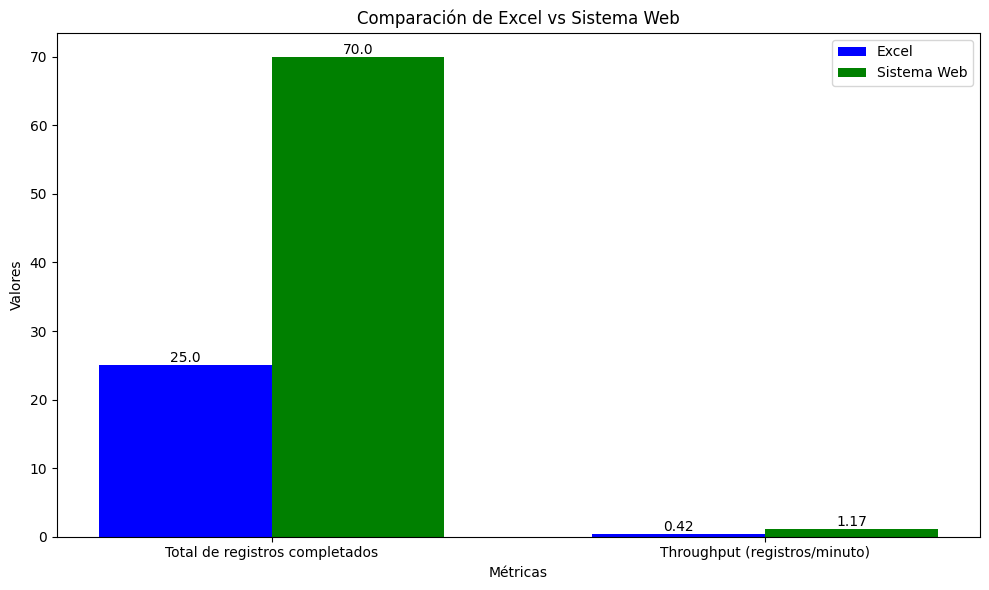

In [8]:

import matplotlib.pyplot as plt
import numpy as np

# Datos de la tabla
categories = ['Total de registros completados', 'Throughput (registros/minuto)']
excel_values = [25, 0.42]
web_values = [70, 1.17]
differences = [45, 0.75]
improvement_percentages = [180, 178.57]

# Configuración de la gráfica
bar_width = 0.35
index = np.arange(len(categories))

# Crear las subplots
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# Graficar los valores de Excel y Sistema Web
bars1 = ax1.bar(index, excel_values, bar_width, label='Excel', color='blue')
bars2 = ax1.bar(index + bar_width, web_values, bar_width, label='Sistema Web', color='green')

# Añadir etiquetas, título y leyenda
ax1.set_xlabel('Métricas')
ax1.set_ylabel('Valores')
ax1.set_title('Comparación de Excel vs Sistema Web')
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(categories)
ax1.legend()

# Mostrar los valores sobre las barras
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, yval, round(yval, 2), ha='center', va='bottom')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

